In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### Helper functions

In [2]:
def load_data(dataset: str, channels: int = 1):
  
    df = pd.read_csv(dataset)
  
    df['category'] = df['category'].str.strip()

    train = df.loc[df.category == 'Training',:]
    valid = df.loc[df.category == 'PublicTest',:]
    test  = df.loc[df.category == 'PrivateTest',:]

    del train['Unnamed: 0']
    del valid['Unnamed: 0']
    del test['Unnamed: 0']

    X_train = np.array(train.iloc[:, 1:2305])
    y_train = np.array(train.loc[:, ['y']])

    X_val = np.array(valid.iloc[:, 1:2305])
    y_val = np.array(valid.loc[:, ['y']])

    X_test = np.array(test.iloc[:, 1:2305])
    y_test = np.array(test.loc[:, ['y']])

    del train
    del valid
    del test

    y_train = keras.utils.to_categorical(y_train, 7)
    y_val = keras.utils.to_categorical(y_val, 7)
    y_test = keras.utils.to_categorical(y_test, 7)

    X_train_r = X_train.reshape((len(X_train), 48, 48))
    X_val_r   = X_val.reshape((len(X_val), 48, 48))
    X_test_r   = X_test.reshape((len(X_test), 48, 48))

    X_train_r = X_train_r / 255
    X_val_r = X_val_r / 255
    X_test_r = X_test_r / 255

    if channels == 1:
        X_train_bw = X_train_r.reshape((len(X_train_r), 48, 48, 1))
        X_val_bw = X_val_r.reshape((len(X_val_r), 48, 48, 1))
        X_test_bw = X_test_r.reshape((len(X_test_r), 48, 48, 1))
        return (X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test)
    elif channels == 3:
        X_train_rgb = np.stack((X_train_r,) * 3, axis = -1)
        X_val_rgb = np.stack((X_val_r, ) * 3, axis = -1)
        X_test_rgb = np.stack((X_test_r, ) * 3, axis = -1)
        return (X_train_rgb, X_val_rgb, X_test_rgb, y_train, y_val, y_test)
    else:
        return None

In [3]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

### Data preparation

#### Reading data

In [6]:
X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test = load_data('emotions.csv')

#### Displaying total counts of different labels

In [7]:
import collections
dict(collections.Counter(np.argmax(y_train, axis = 1)))

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

### VGG Model

In [22]:
from keras.models import Sequential
from keras.optimizers import SGD,Adadelta
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.advanced_activations import PReLU
import keras

from keras.metrics import categorical_accuracy

np.random.seed(100)

### Model definition

In [44]:
img_rows, img_cols = 48, 48

model = Sequential()

model.add(Conv2D(64, (5, 5), padding="valid",
                        input_shape=(img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(ZeroPadding2D(padding=(2, 2), data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(PReLU(alpha_initializer='zero', weights=None)) 
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(Dropout(0.5))

model.add(Dense(1024))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(Dropout(0.5))

model.add(Dense(7))

model.add(Activation('softmax'))

ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 44, 44, 64)        123904    
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
p_re_lu_9 (PReLU)            (None, 22, 22, 64)        30976     
__________

In [52]:
"Training with augmented data. Augmentation takes place while training"

from keras.preprocessing.image import ImageDataGenerator

#Generate augmented data
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

valgen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False) 

datagen.fit(X_train_bw)
valgen.fit(X_val_bw)

model.load_weights('vgg.h5')

model.fit(X_train_bw, y_train, batch_size=128, epochs=30, validation_data=(X_val_bw, y_val))

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 31s 1ms/step - loss: 0.4942 - categorical_accuracy: 0.8254 - val_loss: 1.1046 - val_categorical_accuracy: 0.6503
Epoch 2/30
28709/28709 [==============================] - 31s 1ms/step - loss: 0.4926 - categorical_accuracy: 0.8255 - val_loss: 1.1312 - val_categorical_accuracy: 0.6383
Epoch 3/30
28709/28709 [==============================] - 32s 1ms/step - loss: 0.4866 - categorical_accuracy: 0.8283 - val_loss: 1.0853 - val_categorical_accuracy: 0.6548
Epoch 4/30
28709/28709 [==============================] - 32s 1ms/step - loss: 0.4831 - categorical_accuracy: 0.8318 - val_loss: 1.0989 - val_categorical_accuracy: 0.6447
Epoch 5/30
28709/28709 [==============================] - 31s 1ms/step - loss: 0.4881 - categorical_accuracy: 0.8277 - val_loss: 1.1003 - val_categorical_accuracy: 0.6517
Epoch 6/30
28709/28709 [==============================] - 32s 1ms/step - loss: 0.4863 - categori

In [51]:
model.save_weights('vgg.h5')

In [54]:
model_json = model.to_json()

In [55]:
with open("vgg.json", "w") as json_file:
    json_file.write(model_json)

### Evaluation

In [56]:
model.evaluate(X_test_bw, y_test)

3589/3589 [==============================] - 2s 457us/step


[1.066487466103189, 0.6645305098996385]

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [59]:
y['pred'] = model.predict_classes(X_test_bw)

In [60]:
y['true'] = y['true'].map(mapping)

In [61]:
y['pred'] = y['pred'].map(mapping)

In [62]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


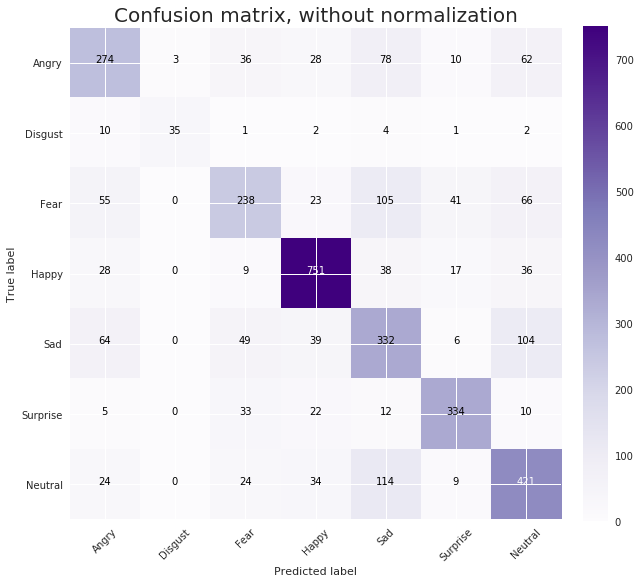

In [63]:
cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)


plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


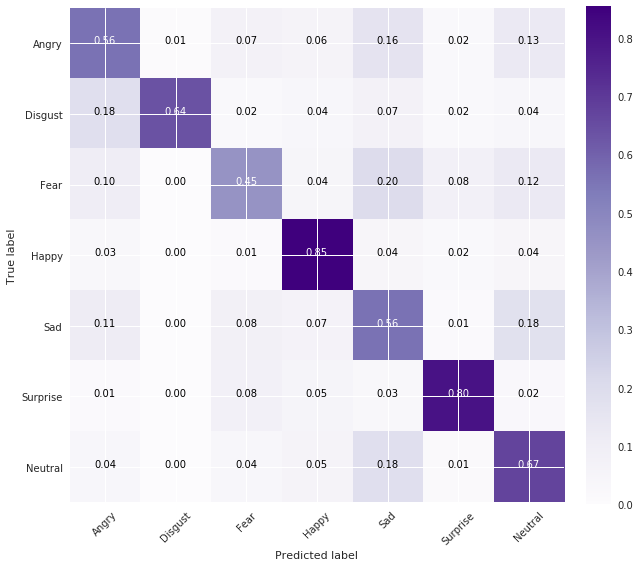

In [64]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')
# plt.savefig('../images/confusion.png')